<a href="https://colab.research.google.com/github/Swami-Siva-Rama-Raju/ML-Algorithms-Projects/blob/main/Sentiment_Analysis_on_Movie_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


**Understanding dataset**

In [2]:
movies_df=pd.read_csv("/content/drive/MyDrive/SVM/IMDB Dataset.csv")

In [3]:
movies_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
movies_df.shape

(50000, 2)

In [5]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
movies_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
movies_df.dtypes

,0
review,object
sentiment,object


**Data cleaning**

In [8]:
movies_df.isnull().sum()

,0
review,0
sentiment,0


In [9]:
movies_df.duplicated().sum()

418

In [10]:
#Drop the duplicate rows
movies_df.drop_duplicates(inplace=True)

In [11]:
movies_df.duplicated().sum()

0

In [12]:
movies_df.shape

(49582, 2)

In [13]:
movies_df['num_characters']=movies_df['review'].apply(len)

In [14]:
movies_df.head()

,review,sentiment,num_characters
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
3,Basically there's a family where a little boy ...,negative,748
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317


In [15]:
movies_df['num_words']=movies_df['review'].apply(lambda x:len(nltk.word_tokenize(x)))

In [16]:
movies_df.head()

,review,sentiment,num_characters,num_words
0,One of the other reviewers has mentioned that ...,positive,1761,380
1,A wonderful little production. <br /><br />The...,positive,998,201
2,I thought this was a wonderful way to spend ti...,positive,926,205
3,Basically there's a family where a little boy ...,negative,748,175
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,283


In [17]:
movies_df['num_sentences']=movies_df['review'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [18]:
movies_df.head()

,review,sentiment,num_characters,num_words,num_sentences
0,One of the other reviewers has mentioned that ...,positive,1761,380,10
1,A wonderful little production. <br /><br />The...,positive,998,201,7
2,I thought this was a wonderful way to spend ti...,positive,926,205,4
3,Basically there's a family where a little boy ...,negative,748,175,6
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,283,9


In [19]:
movies_df.describe()

,num_characters,num_words,num_sentences
count,49582.000000,49582.000000,49582.000000
mean,1310.568230,279.711226,10.741519
std,990.762238,208.167050,7.817026
min,32.000000,8.000000,1.000000
25%,699.000000,151.000000,6.000000
50%,971.000000,209.000000,9.000000
75%,1592.000000,340.000000,13.000000
max,13704.000000,2911.000000,282.000000


**EDA**

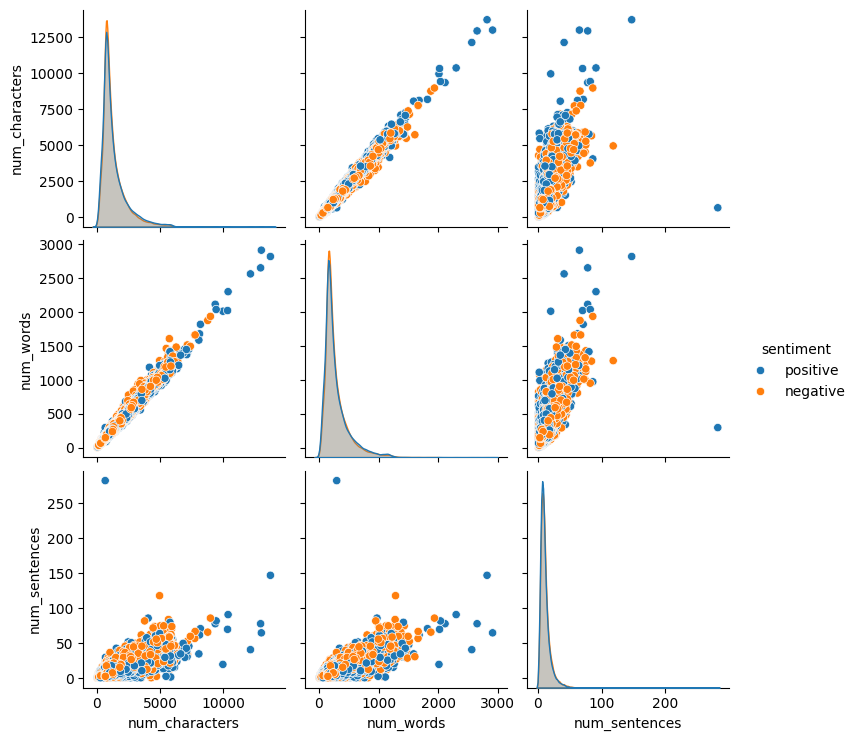

In [20]:
sns.pairplot(movies_df,hue='sentiment')
plt.show()

In [21]:
movies_df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

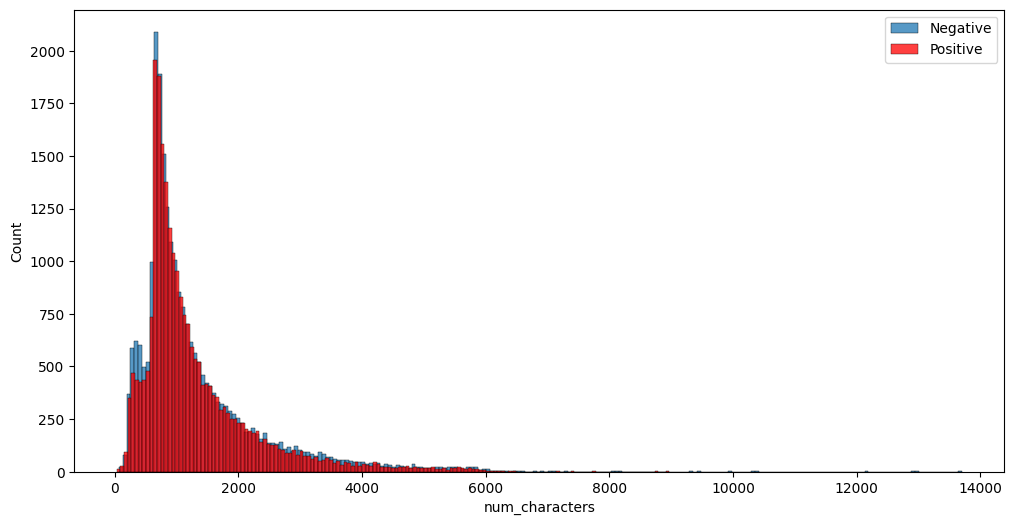

In [22]:
plt.figure(figsize=(12,6))
sns.histplot(movies_df[movies_df['sentiment']=='positive']['num_characters'])
sns.histplot(movies_df[movies_df['sentiment']=='negative']['num_characters'],color='red')
plt.legend(['Negative','Positive'])
plt.show()

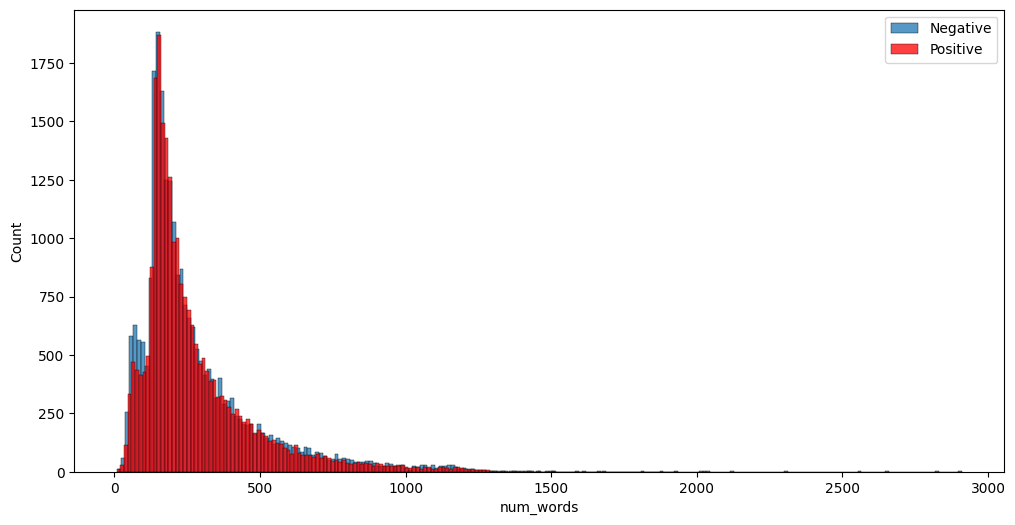

In [23]:
plt.figure(figsize=(12,6))
sns.histplot(movies_df[movies_df['sentiment']=='positive']['num_words'])
sns.histplot(movies_df[movies_df['sentiment']=='negative']['num_words'],color='red')
plt.legend(['Negative','Positive'])
plt.show()

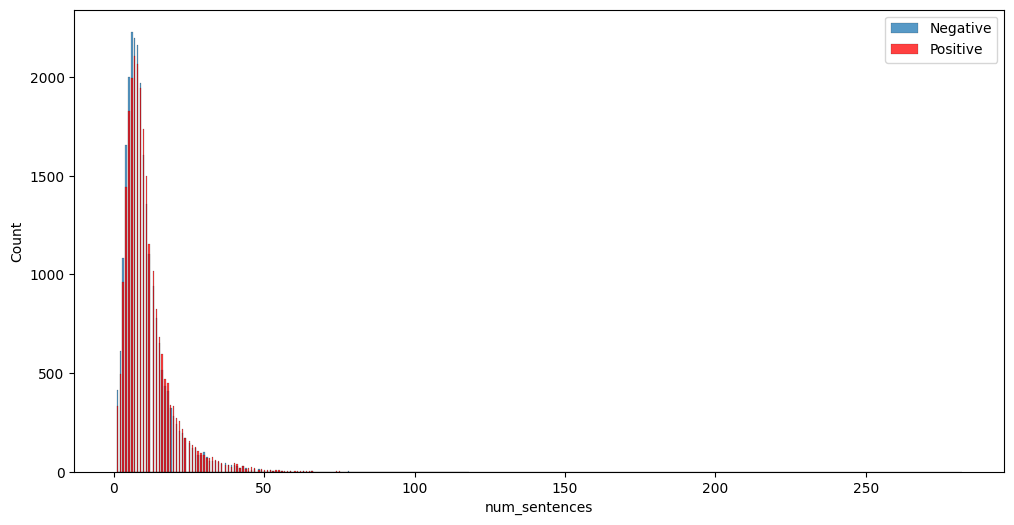

In [24]:
plt.figure(figsize=(12,6))
sns.histplot(movies_df[movies_df['sentiment']=='positive']['num_sentences'])
sns.histplot(movies_df[movies_df['sentiment']=='negative']['num_sentences'],color='red')
plt.legend(['Negative','Positive'])
plt.show()

*You can clearly see that negative reviews have more characters than positive*

In [25]:
wc=WordCloud(width=500,height=500,min_font_size=10,background_color='black')

In [26]:
pwc=wc.generate(movies_df[movies_df['sentiment']=='positive']['review'].str.cat(sep=" "))

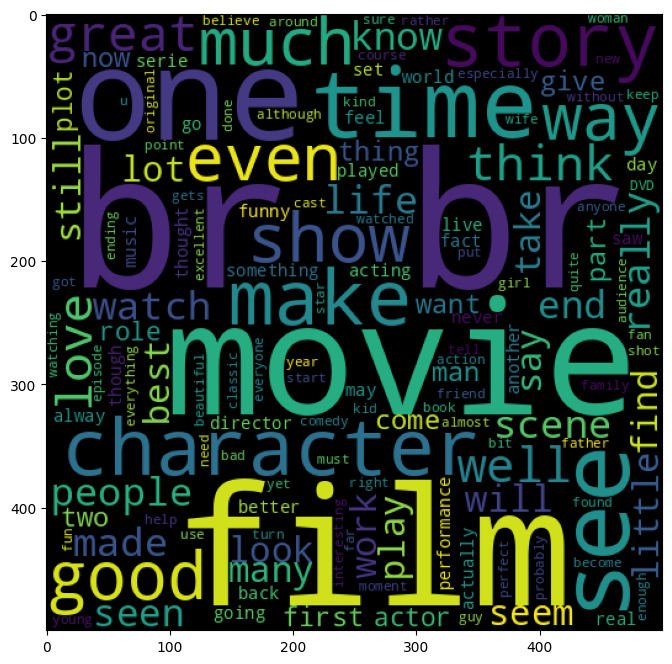

In [27]:
plt.figure(figsize=(15,8))
plt.imshow(pwc)
plt.show()

In [28]:
nwc=wc.generate(movies_df[movies_df['sentiment']=='negative']['review'].str.cat(sep=" "))

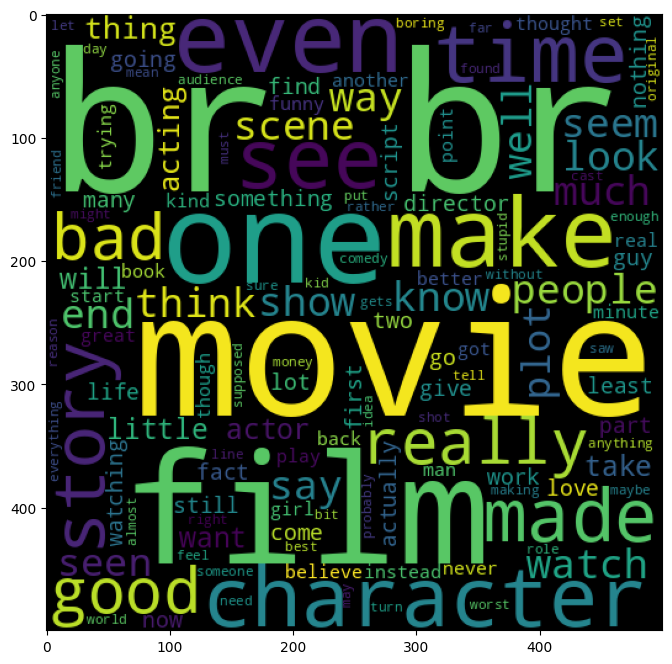

In [29]:
plt.figure(figsize=(15,8))
plt.imshow(nwc)
plt.show()

# **Data Preprocessing**


1.   Lower case
2.   Remove spl characters
3.   Remove punctuations and stop words
4.   Stemming
5.   Tokenization








In [30]:
#punctuations
import string
punc=string.punctuation

In [31]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
punc = set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

def preprocess_review(review):
    review = re.sub('[^a-zA-Z]', ' ', review).lower()
    review = review.split()
    review = [ps.stem(word) for word in review if word not in stop_words and word not in punc]
    return ' '.join(review)

movies_df['cleaned_review'] = movies_df['review'].apply(preprocess_review)


In [32]:
movies_df.head()

,review,sentiment,num_characters,num_words,num_sentences,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,1761,380,10,one review mention watch oz episod hook right ...
1,A wonderful little production. <br /><br />The...,positive,998,201,7,wonder littl product br br film techniqu unass...
2,I thought this was a wonderful way to spend ti...,positive,926,205,4,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,negative,748,175,6,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,283,9,petter mattei love time money visual stun film...


In [33]:
movies_df.drop('review',axis=1,inplace=True)

In [34]:
movies_df.head()

,sentiment,num_characters,num_words,num_sentences,cleaned_review
0,positive,1761,380,10,one review mention watch oz episod hook right ...
1,positive,998,201,7,wonder littl product br br film techniqu unass...
2,positive,926,205,4,thought wonder way spend time hot summer weeke...
3,negative,748,175,6,basic famili littl boy jake think zombi closet...
4,positive,1317,283,9,petter mattei love time money visual stun film...


In [35]:
#label encoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
movies_df['sentiment']=le.fit_transform(movies_df['sentiment'])

In [36]:
movies_df.head()

,sentiment,num_characters,num_words,num_sentences,cleaned_review
0,1,1761,380,10,one review mention watch oz episod hook right ...
1,1,998,201,7,wonder littl product br br film techniqu unass...
2,1,926,205,4,thought wonder way spend time hot summer weeke...
3,0,748,175,6,basic famili littl boy jake think zombi closet...
4,1,1317,283,9,petter mattei love time money visual stun film...


0.   Negative
1.   Positive

In [37]:
movies_df.rename(columns={'cleaned_review': 'review'}, inplace=True)

In [38]:
movies_df.head()

,sentiment,num_characters,num_words,num_sentences,review
0,1,1761,380,10,one review mention watch oz episod hook right ...
1,1,998,201,7,wonder littl product br br film techniqu unass...
2,1,926,205,4,thought wonder way spend time hot summer weeke...
3,0,748,175,6,basic famili littl boy jake think zombi closet...
4,1,1317,283,9,petter mattei love time money visual stun film...


**Model Building**

In [39]:
#seperating independent and dependent features
X=movies_df['review']
y=movies_df['sentiment']

In [40]:
#count vectorizer to review column
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
X=cv.fit_transform(X)

In [41]:
X.shape

(49582, 68997)

In [42]:
#train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [43]:
#import gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [44]:
import xgboost as xgb

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Fit the model
xgb_clf.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:04:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [45]:
#predict
y_pred=xgb_clf.predict(X_test)

In [46]:
#import adaboost
import lightgbm as lgb

# Initialize the LightGBM classifier
lgb_clf = lgb.LGBMClassifier()
X_train=X_train.astype('float32')
y_train=y_train.astype('float32')
# Fit the model
lgb_clf.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 19906, number of negative: 19759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 11.140597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45945
[LightGBM] [Info] Number of data points in the train set: 39665, number of used features: 11009
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501853 -> initscore=0.007412
[LightGBM] [Info] Start training from score 0.007412


LGBMClassifier()

In [47]:
#predict
X_test=X_test.astype('float32')
y_pred_lgb = lgb_clf.predict(X_test)

**Model Evaluation**

*XG boosting*

In [48]:
#confusion matrix
print(confusion_matrix(y_test,y_pred))

[[4098  841]
 [ 601 4377]]


In [49]:
#classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4939
           1       0.84      0.88      0.86      4978

    accuracy                           0.85      9917
   macro avg       0.86      0.85      0.85      9917
weighted avg       0.86      0.85      0.85      9917



In [50]:
#accuracy
accuracy_score(y_test,y_pred)

0.8545931229202379

*LG Boosting*

In [51]:
#confusion matrix
print(confusion_matrix(y_test,y_pred_lgb))

[[4089  850]
 [ 641 4337]]


In [52]:
#classification report
print(classification_report(y_test,y_pred_lgb))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      4939
           1       0.84      0.87      0.85      4978

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



In [53]:
#accuracy
accuracy_score(y_test,y_pred_lgb)

0.8496521125340325